2020-09-12, Bogumił Kamiński

A companion notebook to the blog post:
https://bkamins.github.io/julialang/2020/08/22/sir.html

Load required packages

In [1]:
using PyPlot
using StatsBase

Define agent type

In [2]:
@enum AgentType agentS agentI agentR agentD

In [3]:
struct Agent
    x::Int # location of an agent in x-dimension
    y::Int # location of an agent in y-dimension
    type::AgentType # type of an agent
    tick::Int # moment in time when agent entered type `type`
end

Define type holding information about simulation environment

In [4]:
mutable struct Environment
    grid::Matrix{Vector{Int}} # for each cell of a grid a vector of numbers
                              # of agents currently occupying a given cell
    agents::Vector{Agent}     # a vector of all agents
    duration::Int             # metadata: how long agent stays in infected state
    pdeath::Float64           # metadata: probability of death of an agent after
                              # being infected
    stats::Dict{AgentType, Vector{Int}} # a dictionary storing number of agents
                                        # of each type in consecutive ticks
                                        # of the simulation
    tick::Int                 # counter of the current tick of the simulation
end

Routine initializing the simulation

In [5]:
function init(n::Int, infected::Int,
              duration::Int, pdeath::Float64, xdim::Int, ydim::Int)
    grid = [Int[] for _ in 1:xdim, _ in 1:ydim]
    agents = [Agent(rand(1:xdim), rand(1:ydim),
                    i <= infected ? agentI : agentS, 0) for i in 1:n]
    for (i, a) in enumerate(agents)
        push!(grid[a.x, a.y], i)
    end
    stats = Dict(agentS => [n - infected],
                 agentI => [infected],
                 agentR => [0],
                 agentD => [0])
    return Environment(grid, agents, duration, pdeath, stats, 0)
end

init (generic function with 1 method)

Definitions of actions that agent can make

In [6]:
die(a::Agent, tick::Int) = Agent(a.x, a.y, agentD, tick)

die (generic function with 1 method)

In [7]:
recover(a::Agent, tick::Int) = Agent(a.x, a.y, agentR, tick)

recover (generic function with 1 method)

In [8]:
infect(a::Agent, tick::Int) = Agent(a.x, a.y, agentI, tick)

infect (generic function with 1 method)

In [9]:
move(a::Agent, dims::Tuple{Int, Int}) =
    if a.type == agentD
        a
    else
        Agent(mod1(a.x + rand(-1:1), dims[1]),
              mod1(a.y + rand(-1:1), dims[2]),
              a.type, a.tick)
    end

move (generic function with 1 method)

A global routine that updates types of agents in a single tick

In [10]:
function update_type!(env::Environment)
    tick = env.tick
    for (i, a) in enumerate(env.agents)
        if a.type == agentI
            if tick - a.tick > env.duration
                env.agents[i] = if rand() < env.pdeath
                    die(a, tick)
                else
                    recover(a, tick)
                end
            else
                a.tick == tick && continue
                for j in env.grid[a.x, a.y]
                    a2 = env.agents[j]
                    if a2.type == agentS
                        env.agents[j] = infect(a2, tick)
                    end
                end
            end
        end
    end
end

update_type! (generic function with 1 method)

Routine handling of movement of all agents

In [11]:
function move_all!(grid::Matrix{Vector{Int}}, agents::Vector{Agent})
    foreach(empty!, grid)
    for (i, agent) in enumerate(agents)
        a = move(agent, size(grid))
        agents[i] = a
        push!(grid[a.x, a.y], i)
    end
end

move_all! (generic function with 1 method)

Helper function for collection of simulation statistics

In [12]:
function get_statistics!(env::Environment)
    status = countmap([a.type for a in env.agents])
    for (k, v) in env.stats
        push!(v, get(status, k, 0))
    end
end

get_statistics! (generic function with 1 method)

Main routine for running simulations

In [13]:
function run!(env::Environment)
    while env.stats[agentI][end] > 0
        env.tick += 1
        update_type!(env)
        move_all!(env.grid, env.agents)
        get_statistics!(env)
    end
end

run! (generic function with 1 method)

Perform a single run of our simulation

In [14]:
e = init(2000, 10, 21, 0.05, 100, 100)

Environment([Int64[] Int64[] … [1135] Int64[]; Int64[] Int64[] … Int64[] Int64[]; … ; Int64[] Int64[] … Int64[] [1274]; Int64[] Int64[] … Int64[] Int64[]], Agent[Agent(65, 81, agentI, 0), Agent(51, 46, agentI, 0), Agent(5, 94, agentI, 0), Agent(27, 99, agentI, 0), Agent(74, 34, agentI, 0), Agent(12, 4, agentI, 0), Agent(94, 49, agentI, 0), Agent(94, 83, agentI, 0), Agent(21, 86, agentI, 0), Agent(89, 11, agentI, 0)  …  Agent(32, 52, agentS, 0), Agent(3, 23, agentS, 0), Agent(87, 11, agentS, 0), Agent(11, 22, agentS, 0), Agent(50, 14, agentS, 0), Agent(87, 93, agentS, 0), Agent(45, 13, agentS, 0), Agent(99, 71, agentS, 0), Agent(49, 12, agentS, 0), Agent(66, 69, agentS, 0)], 21, 0.05, Dict{AgentType,Array{Int64,1}}(agentD => [0],agentS => [1990],agentI => [10],agentR => [0]), 0)

In [15]:
run!(e)

Plot the results

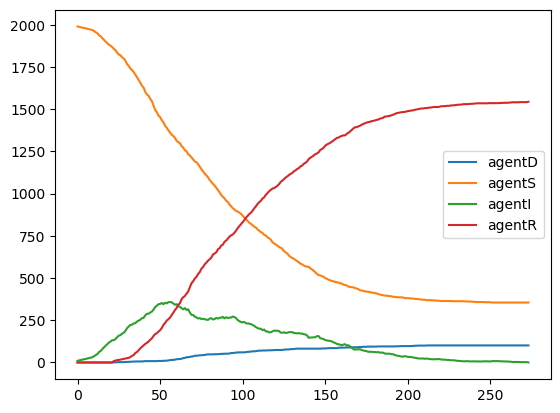

PyObject <matplotlib.legend.Legend object at 0x7f5e7e676bd0>

In [16]:
foreach(plot, values(e.stats))
legend(string.(keys(e.stats)))

Define a helper function counting a fraction of infected agents at the end of the simulation

In [17]:
function fraction_infected(l)
    e = init(2000, 10, l, 0.05, 100, 100)
    run!(e)
    return 1 - e.stats[agentS][end] / 2000
end

fraction_infected (generic function with 1 method)

Now run a simulation for different values of `duration` (16 times for each value)

In [18]:
len = 5:30
runs = 16
inf = [sum(fraction_infected(l) for r in 1:runs) / runs for l in len]

26-element Array{Float64,1}:
 0.018124999999999974
 0.02193749999999999
 0.03040624999999999
 0.04293750000000001
 0.06146875000000001
 0.09006249999999999
 0.13025
 0.18446875000000001
 0.2669375
 0.3621875
 0.40771874999999996
 0.5521875
 0.6359375
 0.6985312499999998
 0.7406562499999998
 0.8148750000000001
 0.8330625
 0.8565625000000001
 0.874
 0.9031562500000001
 0.91071875
 0.9226249999999998
 0.9350312500000002
 0.9441249999999998
 0.9506562499999999
 0.9595000000000001

and show the results

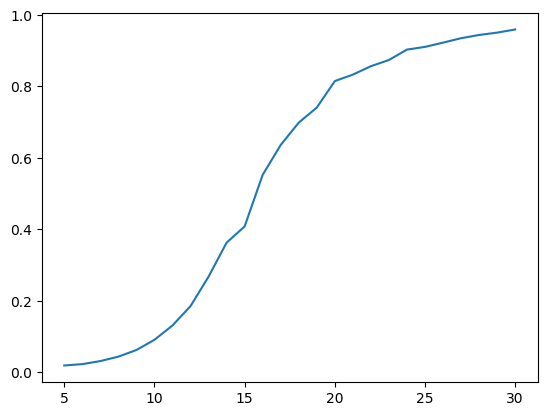

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5e62fca510>

In [19]:
plot(len, inf)